# core

> Fill in a module description here

In [1]:
#| default_exp preprocessing

In [5]:
#| export
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from fastcore.basics import patch
from fastcore.all import *
#from fastai.vision.all import *
from dataclasses import dataclass, field

from typing import Union, List, Tuple, Optional, Callable, Dict, Any

2023-04-12 23:46:03.576287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 23:46:03.770828: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
#| hide
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
#| export
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCS = 5
BATCH_SIZE = 10
BUFFER_SIZE = 30
class_names = ['Pin']
train_count = 107
test_count = 27
num_classes = len(class_names)
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE


In [5]:
#| hide
from nbdev.showdoc import *

In [6]:
data_path = Path.cwd().parent.parent.parent/'data_first/Trainingsdata_1024_1224'

#data_path.ls()

In [10]:
#| export
@dataclass
class Preprocess:
    image_path:Union[Path, str]
    label_path:Union[Path, str]
    im_height:int = IMAGE_HEIGHT
    im_width:int = IMAGE_WIDTH
    bf_size:int = BUFFER_SIZE
    bs:int = BATCH_SIZE
    test_size:float = 0.2
    img_ext:str = field(default_factory=str, init=False, repr=True)

    def __post_init__(self):
        self.img_ext = Path(self.image_path).ls()[0].suffix
        pat = f'*{self.img_ext}'
        self.images = [str(i) for i in Path(self.image_path).rglob(pat)]
        self.labels = [str(i) for i in Path(self.label_path).rglob(pat)]
        self.train_images, self.test_images, \
            self.train_labels, self.test_labels = train_test_split(
                         self.images,
                         self.labels, 
                         test_size=self.test_size,
                         random_state=42)


In [8]:
preprocess_obj = Preprocess(
                           image_path=data_path/'X',
                           label_path=data_path/'y',
                           im_height=IMAGE_HEIGHT,
                           im_width=IMAGE_WIDTH,
                           bs=BATCH_SIZE
                           )

In [9]:
#| export
@patch_to(Preprocess)
def from_file_to_image(
                       self,
                       im_file,
                       ):
    image = tf.io.read_file(im_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(
                            image, 
                            (self.im_height, self.im_width, ))
    return image


In [11]:
#| export
@patch_to(Preprocess)
def show_image(self,im_file):
    #image = self.from_file_to_image(im_file)
    plt.imshow(im_file)
    plt.axis('off')
    plt.show()

2023-04-12 22:18:48.864533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 22:18:48.882440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 22:18:48.884924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 22:18:48.891208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FM

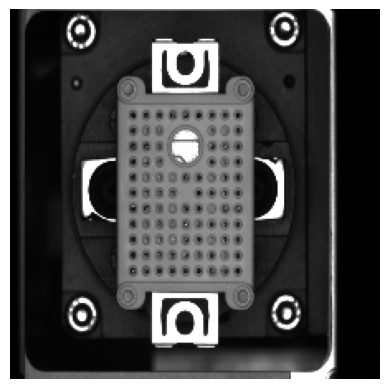

In [11]:
preprocess_obj.show_image(
    preprocess_obj.from_file_to_image(
    preprocess_obj.images[0]
    )
    )

In [12]:
#| export
@ patch_to(Preprocess)
def normalize(self, image, min=0):
    def _normalize(im):
        img = tf.cast(im, tf.float32)
        return img / 255.0

    if min == 0:
        return _normalize(image)
    else:
        return (_normalize(image) * 2.0) -1.0

In [13]:
#| export
@ patch_to(Preprocess)
def process_image_file(
                       self,
                       im_file:str,
                       norm:bool=False
                       ):
    image = self.from_file_to_image(im_file)
    if norm:
        image = self.normalize(image)
    image = tf.reshape(image, (self.im_height, self.im_width, 1,))
    return image

In [12]:
#| export
@ patch_to(Preprocess)
def process_image_and_label(
                       self,
                       im_file:str,
                       lbl_file:str,
                       norm:bool=True
                       ):
    return self.process_image_file(im_file, norm=norm), self.process_image_file(lbl_file, norm=norm) 

In [15]:
pr_img = preprocess_obj.process_image_file(
           im_file=preprocess_obj.train_images[0],
           norm=False)
test_eq(pr_img.shape, (IMAGE_HEIGHT, IMAGE_WIDTH, 1,))

In [13]:
#| export
@patch_to(Preprocess)
def create_dataset(
                  self,
                  images, labels,
                  train:bool=True
                  ):
    _dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    _dataset = _dataset.map(
                            self.process_image_and_label, 
                            num_parallel_calls=tf.data.AUTOTUNE
                            )
    if train:
        return  _dataset\
               .cache()\
               .shuffle(
                        self.bf_size,
                        reshuffle_each_iteration=True)\
               .batch(self.bs)\
               .repeat()\
               .prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        return  _dataset.batch(self.bs).repeat()


In [14]:
#| export
@patch_to(Preprocess)
def create_train_test_dataset(self):
    self.train_dataset = self.create_dataset(
                                            images=self.train_images, 
                                            labels=self.train_labels,
                                            train=True)
    self.test_dataset = self.create_dataset(
                                           self.test_images,
                                           self.test_labels,
                                           train=False)
    return self.train_dataset, self.test_dataset

In [18]:
#| hide
train_ds, test_ds = preprocess_obj.create_train_test_dataset()

In [19]:
#| hide
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

In [21]:
#| export
def foo(): pass

In [1]:
#| hide
import nbdev; nbdev.nbdev_export()